In [1]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.1 MB/s 
  Created wheel for pyod: filename=pyod-1.0.3-py3-none-any.whl size=154726 sha256=b082be7da4a55b0609ca652e6f5f412a169bb9dbfff4f9b63bacab74dfae49df
  Stored in directory: /root/.cache/pip/wheels/60/1e/04/b42e786399bd7503af674d1ec95d93665b1700309ec3525b65
Successfully built pyod


In [2]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42884 sha256=e5787d0aebb6a6f69bbaa58b83e71b2e8be138002a55459b5beba49ed5b47e31
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully built combo


In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
from pyod.models import knn, lof, hbos, iforest,ocsvm


from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.feature_bagging import FeatureBagging
def train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
    print("Total time: ", span, "s.")

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test

def co_train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
#    print("Train time: ", time_to_train, "s.")
#    print("Test time: ", time_to_test, "s.")
    

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores,clf.threshold_, time_to_train, time_to_test 

def my_metric(label,predict):
    CM = confusion_matrix(label,predict)
    CR = classification_report(label,predict)
    fpr, tpr, thresholds = roc_curve(label, predict)
    precision=precision_score(label, predict)
    recall=recall_score(label, predict)
    accuracy = accuracy_score(label, predict)
    f1=f1_score(label, predict, average='weighted')
    #AUC = auc(fpr, tpr)
    AUC=metrics.auc(fpr, tpr)

    results = {"Confusion Matrix":CM,"Classification Report":CR,"Area Under Curve":AUC}

    # show results
    for measure in results:
        print(measure,": \n",results[measure])
#     plt.plot(fpr, recall, 'k--', label='ROC (area = {0:.2f})'.format(AUC), lw=2)
    return fpr,tpr,f1,AUC, recall, accuracy
def baseline(X_train, X_test, y_train, y_test,model):
    start = time.time()

    if model == "knn":
        print ("Base Detector:"+model)
        clf = knn.KNN()
    elif model == "lof":
        print ("Base Detector:"+model)
        clf = lof.LOF()
    elif model == "hbos":
        print ("Base Detector:"+model)
        clf = hbos.HBOS()
    elif model == "iforest":
        print ("Base Detector:"+model)
        clf = iforest.IForest()
    elif model== "ocsvm":
        print ("Base Detector:"+model)
        clf = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test= train_test(clf, X_train, X_test)
    print("\nTraining set:\n")
    _, _, _, _ ,_, _ = my_metric(y_train, y_train_pred)
    print("\nTest set:\n")
    fpr, tpr, f1, auc, recall, accuracy= my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test, recall, accuracy
def feature_bagging(X_train, X_test, y_train, y_test,basemodel,combination_function="mean"):

    start = time.time()
    #print ("FB base detector:"+basemodel)


    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    if basemodel=="knn":
        base_estimator=knn.KNN()
    elif basemodel=="lof":
        base_estimator = lof.LOF()
    elif basemodel == "hbos":
        base_estimator = hbos.HBOS()
    elif basemodel == "iforest":
        base_estimator = iforest.IForest()
    elif basemodel== "ocsvm":
        base_estimator = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    if combination_function=="mean":
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False)
    else:
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False,combination='max')
    # params
    clf.fit(X_train)

    print("Feature Bagging:")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test = train_test(clf, X_train, X_test)
    print("training set:")
    _,_,_,_, _, _=my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("f1:",f1,"auc:",auc)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test,  recall, accuracy
def minmax(x):
    min=x.min()
    max=x.max()
    x = (x - min) / (max - min)
    return x,min,max
def parameter_ensemble(X_train, X_test, y_train, y_test,basemodel,combination_function="mean",span=10):
    #span :Determine the number of different parameters
    start = time.time()
    #print ("PR base detector:"+basemodel)
    threshold = []
    train_score=[]
    test_score=[]#np.zeros([X_test.shape[0],span])
    time_to_train=0
    time_to_test=0
    
    # for i in range(low, high + 1):
    for i in range(0, span):

        if basemodel == "knn":
            clf = knn.KNN(n_neighbors=i+5)
        elif basemodel == "lof":
            clf = lof.LOF(n_neighbors=i+20)
        elif basemodel == "hbos":
            clf = hbos.HBOS(n_bins=10+i)
        elif basemodel == "iforest":
            clf = iforest.IForest(n_estimators=i+100)
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM(degree=i+3)
        else:
            print("Please select a correct base model!")
        print("parameter ensemble:")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        #_, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        _, _, f1, auc ,  recall, accuracy= my_metric(y_test, y_test_pred)

        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
    print("PE Total time: ", time_to_train+time_to_test, "s.") 
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    # threshold = threshold/span
    
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy =my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc , recall, accuracy= my_metric(y_test, y_test_pred)
    #print("f1:",f1,"auc:",auc)
    
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy

def gram_schmidt(data):
    r, c = data.shape
    data = data.astype("float64")
    data[:, 0] = data[:, 0] / np.linalg.norm(data[:, 0])
    for j in range(1, c):
        y = data[:, j]
        sum = np.zeros((r,))
        for i in range(j):
            sum += np.dot(y, data[:, i]) * data[:, i]
        y -= sum
        y = y / np.linalg.norm(y)
        data[:, j] = y
    return data

def rotated_bagging(X_train, X_test):
    n, d = X_train.shape
    r = int(np.ceil(np.sqrt(d) * 0.5) + 0)
    E = np.random.uniform(size=(d, r))
    E = gram_schmidt(E)
    return np.matmul(X_train, E),np.matmul(X_test, E)

def subsample(data,mul=1):
    n = data.shape[0]
    a = 1 if n <= 50 else 50 / n
    b = 1 if n < 1000 else 1000 / n
    f = np.random.uniform(a, b)
    data = shuffle(data)
    m = np.floor(f * n*mul).astype("int32")
    return data.iloc[0:m]


def roteted_bagging(X_train0, X_test0, y_train, y_test,basemodel,combination_function="mean",loop=10):
    #loop: The number of subsets(Sample some features)

    start = time.time()

    test_score =[]
    threshold=[]
    time_to_train=0
    time_to_test=0
    for i in range(loop):

        X_train, X_test = rotated_bagging(X_train0, X_test0)


        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores, threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        
        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
        _, _, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("RB Total time: ", time_to_train+time_to_test, "s.")
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy=my_metric(y_train, y_train_pred)
    print("test set:")
    #print("f1:",f1,"auc:",auc)
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    

    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy
def variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel,combination_function="mean",loop=30, threshold = 1.9,mul=1):
    #loop: The number of subsets(Sample some data points)
    #threshold: A threshold that determines whether the data is abnormal
    #mul: Controls the size of a subset

    start = time.time()
    n_train=X_train.shape[0]
    N = df.shape[0]

    df = pd.DataFrame(np.concatenate([X_train, X_test],0))
    target = pd.DataFrame(np.concatenate([y_train, y_test],0))
    X_index = df.index

    y_VR = np.zeros((N, 2))
    y_VR = pd.DataFrame(y_VR, index=X_index, columns=['score', 'times'])
    for i in range(loop):
        X_train = subsample(df,mul)
        save = X_train.index

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)

        n1 = X_train.shape[0]
        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        clf.fit(X_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        y_train_scores = y_train_scores[:, np.newaxis]
        scaler = StandardScaler()
        scaler.fit(y_train_scores)
        y_train_scores = scaler.transform(y_train_scores).flatten()

        if combination_function=="mean":
            y_VR.loc[save, "score"] += y_train_scores
        elif combination_function=="max":
            y_VR.loc[save, "score"] = np.max([y_train_scores,y_VR.loc[save, "score"]],0)
        else:
            print("Please select a correct combination function!")
        y_VR.loc[save, "times"] = y_VR.loc[save, "times"] + 1

    # if 0 in set(y_VR["times"]):
    #     # some points are not scored, we simply use a base method to the left data
    #     # we should avoid this situation
    #     has_test = True
    #     train_yvr = y_VR[y_VR["times"] != 0]
    #     test_index = y_VR[y_VR["times"] == 0].index
    #     if combination_function=="mean":
    #         train_score = train_yvr["score"] / train_yvr["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target.loc[train_yvr.index]
    #     X_test = df.loc[test_index]
    #     if X_test.shape[0] > 10:
    #         scaler = StandardScaler()
    #         scaler.fit(X_test)
    #         X_test = scaler.transform(X_test)
    #         y_test = target.loc[test_index]
    #
   #         clf = lof.LOF()
    #         clf.fit(X_test)
    #         test_pred = clf.labels_
    #     else:
    #         test_pred = np.zeros((X_test.shape[0], 1))
    # #     test_score = clf.decision_scores_
    #
    # else:
    #     has_test = False
    #     if combination_function=="mean":
    #         train_score = y_VR["score"] / y_VR["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target
    has_test = False
    if combination_function=="mean":
        train_score = y_VR["score"] / y_VR["times"]
    elif combination_function=="max":
        train_score = y_VR["score"]
    else:
        print("Please select a correct combination function!")
    y_train = target

    # %%
    if not has_test:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        
   
    
        _, _, _, _,_, _= my_metric(target[:n_train], y_train_pred[:n_train])
        #fpr, tpr, f1, auc = my_metric(target[n_train:], y_pred[n_train:])
        fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_train_pred[n_train:])

    else:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        _, _, _, _,_, _= my_metric(y_train, y_train_pred)
        fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, test_pred)

    end = time.time()
    times = end - start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("VR Total time: ", times, "s.")

    return fpr, tpr, f1, auc,0.5*times, 0.5*times,recall, accuracy



In [4]:
unsw = pd.read_csv("../content/drive/MyDrive/data/UNSW_downsized.csv")

target = unsw["attack"]
df = unsw[unsw.columns[0:-1]]
data = df.values
# data=my_normalization(data)

# split data, target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [5]:
#knn
fpr_knn, tpr_knn, f1_knn, auc_knn,time_train_knn,time_test_knn, recall_knn, accuracy_knn=baseline(X_train, X_test, y_train, y_test,model="knn")


Base Detector:knn
Total time:  66.96452140808105 s.

Training set:

Confusion Matrix : 
 [[21717  1977]
 [  783   523]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23694
           1       0.21      0.40      0.27      1306

    accuracy                           0.89     25000
   macro avg       0.59      0.66      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6585102863965794

Test set:

Confusion Matrix : 
 [[21759  1971]
 [  739   531]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.42      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.667525408881412


In [6]:
#feature bagging
fpr_fb_knn, tpr_fb_knn, f1_fb_knn, auc_fb_knn,time_train_fb_knn, time_test_fb_knn, recall_fb_knn, accuracy_fb_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Feature Bagging:
Total time:  380.1536011695862 s.
training set:
Confusion Matrix : 
 [[21761  1933]
 [  739   567]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23694
           1       0.23      0.43      0.30      1306

    accuracy                           0.89     25000
   macro avg       0.60      0.68      0.62     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6762841207529746
test set:
Confusion Matrix : 
 [[21834  1896]
 [  705   565]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.23      0.44      0.30      1270

    accuracy                           0.90     25000
   macro avg       0.60      0.68      0.62     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.6824915137820162
f1: 0.9112266522760903 auc: 0.68249

In [7]:
fpr_fb1_knn, tpr_fb1_knn, f1_fb1_knn, auc_fb1_knn,time_train_fb1_max_knn, time_test_fb1_max_knn, recall_fb1_knn, accuracy_fb1_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Feature Bagging:
Total time:  483.9777948856354 s.
training set:
Confusion Matrix : 
 [[21717  1977]
 [  783   523]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23694
           1       0.21      0.40      0.27      1306

    accuracy                           0.89     25000
   macro avg       0.59      0.66      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6585102863965794
test set:
Confusion Matrix : 
 [[21759  1971]
 [  739   531]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.42      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.667525408881412
f1: 0.9078581932091673 auc: 0.667525

In [8]:
#parameter ensemble
fpr_pe_knn, tpr_pe_knn, f1_pe_knn, auc_pe_knn,time_train_pe_knn, time_test_pe_knn, recall_pe_knn, accuracy_pe_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn")


parameter ensemble:
Confusion Matrix : 
 [[21759  1971]
 [  739   531]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.42      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.667525408881412
parameter ensemble:
Confusion Matrix : 
 [[21815  1915]
 [  745   525]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.22      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6663431451599523
parameter ensemble:
Confusion Matrix : 
 [[21794  1936]
 [  737   533]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [9]:

fpr_pe1_knn, tpr_pe1_knn, f1_pe1_knn, auc_pe1_knn,time_train_pe1_max_knn, time_test_pe1_max_knn, recall_pe1_knn, accuracy_pe1_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[21759  1971]
 [  739   531]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.42      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.667525408881412
parameter ensemble:
Confusion Matrix : 
 [[21815  1915]
 [  745   525]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.22      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6663431451599523
parameter ensemble:
Confusion Matrix : 
 [[21794  1936]
 [  737   533]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [10]:
fpr_pe2_knn, tpr_pe2_knn, f1_pe2_knn, auc_pe2_knn,time_train_pe2_median_knn, time_test_pe2_median_knn, recall_pe2_knn, accuracy_pe2_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[21759  1971]
 [  739   531]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.42      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.667525408881412
parameter ensemble:
Confusion Matrix : 
 [[21815  1915]
 [  745   525]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.22      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6663431451599523
parameter ensemble:
Confusion Matrix : 
 [[21794  1936]
 [  737   533]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [11]:
#rotated bagging
fpr_rb_knn, tpr_rb_knn, f1_rb_knn, auc_rb_knn,time_train_rb_knn, time_test_rb_knn, recall_rb_knn, accuracy_rb_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Confusion Matrix : 
 [[21822  1908]
 [  722   548]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.22      0.43      0.29      1270

    accuracy                           0.89     25000
   macro avg       0.60      0.68      0.62     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6755457558955573
Confusion Matrix : 
 [[21897  1833]
 [  744   526]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.22      0.41      0.29      1270

    accuracy                           0.90     25000
   macro avg       0.60      0.67      0.62     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.6684646167016735
Confusion Matrix : 
 [[21768  1962]
 [  754   516]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [12]:
fpr_rb1_knn, tpr_rb1_knn, f1_rb1_knn, auc_rb1_knn,time_train_rb1_max_knn, time_test_rb1_max_knn, recall_rb1_knn, accuracy_rb1_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Confusion Matrix : 
 [[21727  2003]
 [  789   481]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.38      0.26      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.65      0.60     25000
weighted avg       0.93      0.89      0.90     25000

Area Under Curve : 
 0.6471661175096476
Confusion Matrix : 
 [[21842  1888]
 [  694   576]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.23      0.45      0.31      1270

    accuracy                           0.90     25000
   macro avg       0.60      0.69      0.63     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.686990785443855
Confusion Matrix : 
 [[21729  2001]
 [  783   487]]
Classification Report : 
               precision    recall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [13]:
fpr_rb2_knn, tpr_rb2_knn, f1_rb2_knn, auc_rb2_knn,time_train_rb2_median_knn, time_test_rb2_median_knn, recall_rb2_knn, accuracy_rb2_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


Confusion Matrix : 
 [[21742  1988]
 [  762   508]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.20      0.40      0.27      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.66      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6581120943952802
Confusion Matrix : 
 [[21734  1996]
 [  761   509]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.20      0.40      0.27      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.66      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6583372321822604
Confusion Matrix : 
 [[21711  2019]
 [  791   479]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [14]:
#variable sampling with rotated bagging
fpr_vr_knn, tpr_vr_knn, f1_vr_knn, auc_vr_knn,time_train_vr_knn, time_test_vr_knn, recall_vr_knn, accuracy_vr_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",threshold=1.2,loop=100)


Confusion Matrix : 
 [[22638  1056]
 [ 1035   271]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     23694
           1       0.20      0.21      0.21      1306

    accuracy                           0.92     25000
   macro avg       0.58      0.58      0.58     25000
weighted avg       0.92      0.92      0.92     25000

Area Under Curve : 
 0.5814677916792861
Confusion Matrix : 
 [[22680  1050]
 [ 1020   250]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     23730
           1       0.19      0.20      0.19      1270

    accuracy                           0.92     25000
   macro avg       0.57      0.58      0.58     25000
weighted avg       0.92      0.92      0.92     25000

Area Under Curve : 
 0.5763013030450841
VR Total time:  2.648399591445923 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:

fpr_vr1_knn, tpr_vr1_knn, f1_vr1_knn, auc_vr1_knn,time_train_vr1_max_knn, time_test_vr1_max_knn, recall_vr1_knn, accuracy_vr1_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",combination_function="max",threshold=1.2,loop=100)


Confusion Matrix : 
 [[22591  1103]
 [ 1017   289]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     23694
           1       0.21      0.22      0.21      1306

    accuracy                           0.92     25000
   macro avg       0.58      0.59      0.58     25000
weighted avg       0.92      0.92      0.92     25000

Area Under Curve : 
 0.5873672504627984
Confusion Matrix : 
 [[22643  1087]
 [ 1027   243]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     23730
           1       0.18      0.19      0.19      1270

    accuracy                           0.92     25000
   macro avg       0.57      0.57      0.57     25000
weighted avg       0.92      0.92      0.92     25000

Area Under Curve : 
 0.572765793656324
VR Total time:  2.3792667388916016 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


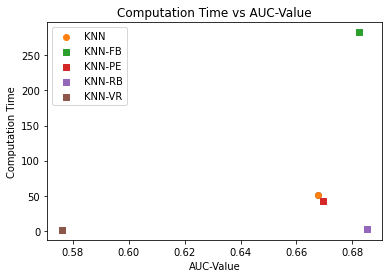

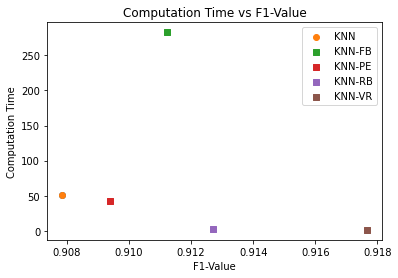

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


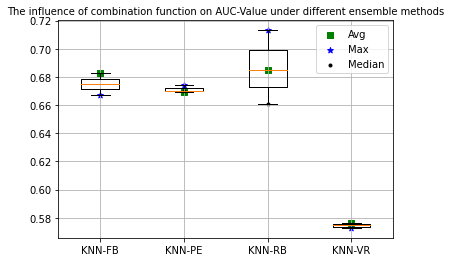

In [16]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_knn,auc_fb_knn, auc_pe_knn, auc_rb_knn , auc_vr_knn]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_knn,f1_fb_knn, f1_pe_knn, f1_rb_knn , f1_vr_knn]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='KNN-FB', "KNN-PE", 'KNN-RB','KNN-VR'

A = [auc_fb_knn,auc_fb1_knn]
B = [auc_pe_knn, auc_pe1_knn, auc_pe2_knn]
C = [auc_rb_knn, auc_rb1_knn, auc_rb2_knn]
D = [auc_vr_knn,auc_vr1_knn]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_knn,auc_pe_knn,auc_rb_knn,auc_vr_knn],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_knn,auc_pe1_knn,auc_rb1_knn,auc_vr1_knn],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_knn,auc_rb2_knn],label="Median",marker='.',c='k')

plt.legend()
plt.show()


In [17]:
#########################LOF
#lof
fpr_lof, tpr_lof, f1_lof, auc_lof,time_train_lof,time_test_lof, recall_lof, accuracy_lof=baseline(X_train, X_test, y_train, y_test,model="lof")


Base Detector:lof
Total time:  32.28157424926758 s.

Training set:

Confusion Matrix : 
 [[21506  2188]
 [  994   312]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     23694
           1       0.12      0.24      0.16      1306

    accuracy                           0.87     25000
   macro avg       0.54      0.57      0.55     25000
weighted avg       0.91      0.87      0.89     25000

Area Under Curve : 
 0.5732766716420478

Test set:

Confusion Matrix : 
 [[21476  2254]
 [  950   320]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5784916265997724


In [18]:
#feature bagging
fpr_fb_lof, tpr_fb_lof, f1_fb_lof, auc_fb_lof,time_train_fb_lof,time_test_fb_lof, recall_fb_lof, accuracy_fb_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Feature Bagging:
Total time:  318.55455350875854 s.
training set:
Confusion Matrix : 
 [[21382  2312]
 [ 1118   188]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.93     23694
           1       0.08      0.14      0.10      1306

    accuracy                           0.86     25000
   macro avg       0.51      0.52      0.51     25000
weighted avg       0.90      0.86      0.88     25000

Area Under Curve : 
 0.5231867748194793
test set:
Confusion Matrix : 
 [[21308  2422]
 [ 1059   211]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92     23730
           1       0.08      0.17      0.11      1270

    accuracy                           0.86     25000
   macro avg       0.52      0.53      0.52     25000
weighted avg       0.91      0.86      0.88     25000

Area Under Curve : 
 0.5320384177641512
f1: 0.8830140653832197 auc: 0.5320

In [19]:
fpr_fb1_lof, tpr_fb1_lof, f1_fb1_lof, auc_fb1_lof,time_train_fb1_max_lof,time_test_fb1_max_lof, recall_fb1_lof, accuracy_fb1_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Feature Bagging:
Total time:  296.8547639846802 s.
training set:
Confusion Matrix : 
 [[21336  2358]
 [ 1164   142]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92     23694
           1       0.06      0.11      0.07      1306

    accuracy                           0.86     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.90      0.86      0.88     25000

Area Under Curve : 
 0.5046050389014297
test set:
Confusion Matrix : 
 [[21231  2499]
 [ 1126   144]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     23730
           1       0.05      0.11      0.07      1270

    accuracy                           0.85     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.90      0.85      0.88     25000

Area Under Curve : 
 0.5040380461291896
f1: 0.8782790391472353 auc: 0.50403

In [20]:
#parameter ensemble
fpr_pe_lof, tpr_pe_lof, f1_pe_lof, auc_pe_lof,time_train_pe_lof,time_test_pe_lof, recall_pe_lof, accuracy_pe_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof")


parameter ensemble:
Confusion Matrix : 
 [[21476  2254]
 [  950   320]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5784916265997724
parameter ensemble:
Confusion Matrix : 
 [[21466  2264]
 [  947   323]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5794620252114503
parameter ensemble:
Confusion Matrix : 
 [[21469  2261]
 [  944   326]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [21]:
fpr_pe1_lof, tpr_pe1_lof, f1_pe1_lof, auc_pe1_lof,time_train_pe1_max_lof,time_test_pe1_max_lof, recall_pe1_lof, accuracy_pe1_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[21476  2254]
 [  950   320]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5784916265997724
parameter ensemble:
Confusion Matrix : 
 [[21466  2264]
 [  947   323]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5794620252114503
parameter ensemble:
Confusion Matrix : 
 [[21469  2261]
 [  944   326]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [22]:
fpr_pe2_lof, tpr_pe2_lof, f1_pe2_lof, auc_pe2_lof,time_train_pe2_median_lof,time_test_pe2_median_lof, recall_pe2_lof, accuracy_pe2_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[21476  2254]
 [  950   320]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5784916265997724
parameter ensemble:
Confusion Matrix : 
 [[21466  2264]
 [  947   323]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23730
           1       0.12      0.25      0.17      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.58      0.55     25000
weighted avg       0.92      0.87      0.89     25000

Area Under Curve : 
 0.5794620252114503
parameter ensemble:
Confusion Matrix : 
 [[21469  2261]
 [  944   326]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [23]:
#rotated bagging
fpr_rb_lof, tpr_rb_lof, f1_rb_lof, auc_rb_lof,time_train_rb_lof,time_test_rb_lof, recall_rb_lof, accuracy_rb_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Confusion Matrix : 
 [[21288  2442]
 [ 1009   261]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.93     23730
           1       0.10      0.21      0.13      1270

    accuracy                           0.86     25000
   macro avg       0.53      0.55      0.53     25000
weighted avg       0.91      0.86      0.88     25000

Area Under Curve : 
 0.5513020496331763
Confusion Matrix : 
 [[21407  2323]
 [ 1003   267]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23730
           1       0.10      0.21      0.14      1270

    accuracy                           0.87     25000
   macro avg       0.53      0.56      0.53     25000
weighted avg       0.91      0.87      0.89     25000

Area Under Curve : 
 0.5561716289888542
Confusion Matrix : 
 [[21362  2368]
 [ 1001   269]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [24]:
fpr_rb1_lof, tpr_rb1_lof, f1_rb1_lof, auc_rb1_lof,time_train_rb1_max_lof,time_test_rb1_max_lof, recall_rb1_lof, accuracy_rb1_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Confusion Matrix : 
 [[21326  2404]
 [  957   313]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     23730
           1       0.12      0.25      0.16      1270

    accuracy                           0.87     25000
   macro avg       0.54      0.57      0.54     25000
weighted avg       0.91      0.87      0.89     25000

Area Under Curve : 
 0.57257516483006
Confusion Matrix : 
 [[21265  2465]
 [ 1008   262]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92     23730
           1       0.10      0.21      0.13      1270

    accuracy                           0.86     25000
   macro avg       0.53      0.55      0.53     25000
weighted avg       0.91      0.86      0.88     25000

Area Under Curve : 
 0.5512111317943664
Confusion Matrix : 
 [[21472  2258]
 [  937   333]]
Classification Report : 
               precision    recall 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [25]:
fpr_rb2_lof, tpr_rb2_lof, f1_rb2_lof, auc_rb2_lof,time_train_rb2_median_lof,time_test_rb2_median_lof, recall_rb2_lof, accuracy_rb2_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


Confusion Matrix : 
 [[21329  2401]
 [ 1036   234]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.93     23730
           1       0.09      0.18      0.12      1270

    accuracy                           0.86     25000
   macro avg       0.52      0.54      0.52     25000
weighted avg       0.91      0.86      0.88     25000

Area Under Curve : 
 0.5415360137504935
Confusion Matrix : 
 [[21400  2330]
 [ 1019   251]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.90      0.93     23730
           1       0.10      0.20      0.13      1270

    accuracy                           0.87     25000
   macro avg       0.53      0.55      0.53     25000
weighted avg       0.91      0.87      0.89     25000

Area Under Curve : 
 0.5497249237650603
Confusion Matrix : 
 [[21302  2428]
 [ 1013   257]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [26]:
#variable sampling with rotated bagging
fpr_vr_lof, tpr_vr_lof, f1_vr_lof, auc_vr_lof,time_train_vr_lof,time_test_vr_lof, recall_vr_lof, accuracy_vr_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof", loop=100)


Confusion Matrix : 
 [[23418   276]
 [ 1294    12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     23694
           1       0.04      0.01      0.02      1306

    accuracy                           0.94     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.90      0.94      0.92     25000

Area Under Curve : 
 0.49876992139828763
Confusion Matrix : 
 [[23442   288]
 [ 1257    13]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     23730
           1       0.04      0.01      0.02      1270

    accuracy                           0.94     25000
   macro avg       0.50      0.50      0.49     25000
weighted avg       0.90      0.94      0.92     25000

Area Under Curve : 
 0.49904984222104976
VR Total time:  2.446301221847534 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
fpr_vr1_lof, tpr_vr1_lof, f1_vr1_lof, auc_vr1_lof,time_train_vr1_max_lof,time_test_vr1_max_lof, recall_vr1_lof, accuracy_vr1_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof",combination_function="max",loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[23632    62]
 [ 1291    15]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     23694
           1       0.19      0.01      0.02      1306

    accuracy                           0.95     25000
   macro avg       0.57      0.50      0.50     25000
weighted avg       0.91      0.95      0.92     25000

Area Under Curve : 
 0.5044343777755458
Confusion Matrix : 
 [[23660    70]
 [ 1254    16]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     23730
           1       0.19      0.01      0.02      1270

    accuracy                           0.95     25000
   macro avg       0.57      0.50      0.50     25000
weighted avg       0.91      0.95      0.92     25000

Area Under Curve : 
 0.5048242863447379
VR Total time:  569.6582827568054 s.


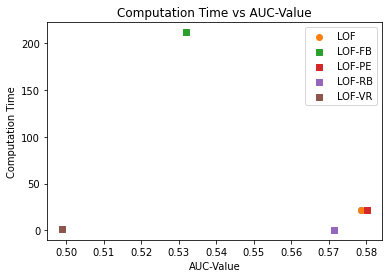

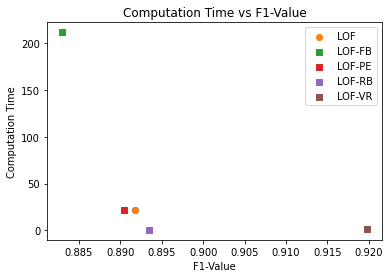

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


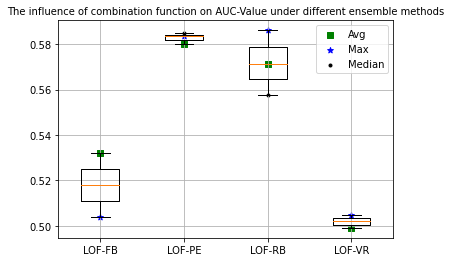

In [28]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_lof,auc_fb_lof, auc_pe_lof, auc_rb_lof , auc_vr_lof]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_lof,f1_fb_lof, f1_pe_lof, f1_rb_lof , f1_vr_lof]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='LOF-FB', "LOF-PE", 'LOF-RB','LOF-VR'
A = [auc_fb_lof,auc_fb1_lof]
B = [auc_pe_lof, auc_pe1_lof, auc_pe2_lof]
C = [auc_rb_lof, auc_rb1_lof, auc_rb2_lof]
D = [auc_vr_lof,auc_vr1_lof]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_lof,auc_pe_lof,auc_rb_lof,auc_vr_lof],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_lof,auc_pe1_lof,auc_rb1_lof,auc_vr1_lof],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_lof,auc_rb2_lof],label="Median",marker='.',c='k')

plt.legend()
plt.show()



In [29]:
##################################HBOS
#hbos
fpr_hbos, tpr_hbos, f1_hbos, auc_hbos,time_train_hbos,time_test_hbos, recall_hbos, accuracy_hbos=baseline(X_train, X_test, y_train, y_test,model="hbos")


Base Detector:hbos
Total time:  2.6129963397979736 s.

Training set:

Confusion Matrix : 
 [[22164  1530]
 [  767   539]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95     23694
           1       0.26      0.41      0.32      1306

    accuracy                           0.91     25000
   macro avg       0.61      0.67      0.64     25000
weighted avg       0.93      0.91      0.92     25000

Area Under Curve : 
 0.6740686284584811

Test set:

Confusion Matrix : 
 [[22159  1571]
 [  789   481]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     23730
           1       0.23      0.38      0.29      1270

    accuracy                           0.91     25000
   macro avg       0.60      0.66      0.62     25000
weighted avg       0.93      0.91      0.92     25000

Area Under Curve : 
 0.6562685195324036


In [30]:
#feature bagging
fpr_fb_hbos, tpr_fb_hbos, f1_fb_hbos, auc_fb_hbos,time_train_fb_hbos,time_test_fb_hbos, recall_fb_hbos, accuracy_fb_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Feature Bagging:
Total time:  0.525313138961792 s.
training set:
Confusion Matrix : 
 [[21909  1785]
 [  742   564]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.95     23694
           1       0.24      0.43      0.31      1306

    accuracy                           0.90     25000
   macro avg       0.60      0.68      0.63     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.6782587291178451
test set:
Confusion Matrix : 
 [[21876  1854]
 [  766   504]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.40      0.28      1270

    accuracy                           0.90     25000
   macro avg       0.59      0.66      0.61     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.6593607215027326
f1: 0.9096847911587145 auc: 0.65936

In [31]:
fpr_fb1_hbos, tpr_fb1_hbos, f1_fb1_hbos, auc_fb1_hbos,time_train_fb1_max_hbos,time_test_fb1_max_hbos, recall_fb1_hbos, accuracy_fb1_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Feature Bagging:
Total time:  0.5638704299926758 s.
training set:
Confusion Matrix : 
 [[21928  1766]
 [  763   543]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     23694
           1       0.24      0.42      0.30      1306

    accuracy                           0.90     25000
   macro avg       0.60      0.67      0.62     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.6706198582720911
test set:
Confusion Matrix : 
 [[21901  1829]
 [  786   484]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.38      0.27      1270

    accuracy                           0.90     25000
   macro avg       0.59      0.65      0.61     25000
weighted avg       0.93      0.90      0.91     25000

Area Under Curve : 
 0.6520134651310179
f1: 0.9094491727785236 auc: 0.6520

In [32]:
#parameter ensemble
fpr_pe_hbos, tpr_pe_hbos, f1_pe_hbos, auc_pe_hbos,time_train_pe_hbos,time_test_pe_hbos, recall_pe_hbos, accuracy_pe_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos")


parameter ensemble:
Confusion Matrix : 
 [[22159  1571]
 [  789   481]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     23730
           1       0.23      0.38      0.29      1270

    accuracy                           0.91     25000
   macro avg       0.60      0.66      0.62     25000
weighted avg       0.93      0.91      0.92     25000

Area Under Curve : 
 0.6562685195324036
parameter ensemble:
Confusion Matrix : 
 [[21734  1996]
 [  743   527]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6654238463554888
parameter ensemble:
Confusion Matrix : 
 [[21731  1999]
 [  745   525]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [33]:
fpr_pe1_hbos, tpr_pe1_hbos, f1_pe1_hbos, auc_pe1_hbos,time_train_pe1_max_hbos,time_test_pe1_max_hbos, recall_pe1_hbos, accuracy_pe1_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[22159  1571]
 [  789   481]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     23730
           1       0.23      0.38      0.29      1270

    accuracy                           0.91     25000
   macro avg       0.60      0.66      0.62     25000
weighted avg       0.93      0.91      0.92     25000

Area Under Curve : 
 0.6562685195324036
parameter ensemble:
Confusion Matrix : 
 [[21734  1996]
 [  743   527]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6654238463554888
parameter ensemble:
Confusion Matrix : 
 [[21731  1999]
 [  745   525]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [34]:
fpr_pe2_hbos, tpr_pe2_hbos, f1_pe2_hbos, auc_pe2_hbos,time_train_pe2_median_hbos,time_test_pe2_median_hbos, recall_pe2_hbos, accuracy_pe2_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[22159  1571]
 [  789   481]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     23730
           1       0.23      0.38      0.29      1270

    accuracy                           0.91     25000
   macro avg       0.60      0.66      0.62     25000
weighted avg       0.93      0.91      0.92     25000

Area Under Curve : 
 0.6562685195324036
parameter ensemble:
Confusion Matrix : 
 [[21734  1996]
 [  743   527]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6654238463554888
parameter ensemble:
Confusion Matrix : 
 [[21731  1999]
 [  745   525]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [35]:
#rotated bagging
fpr_rb_hbos, tpr_rb_hbos, f1_rb_hbos, auc_rb_hbos,time_train_rb_hbos,time_test_rb_hbos, recall_rb_hbos, accuracy_rb_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Confusion Matrix : 
 [[23286   444]
 [ 1015   255]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     23730
           1       0.36      0.20      0.26      1270

    accuracy                           0.94     25000
   macro avg       0.66      0.59      0.61     25000
weighted avg       0.93      0.94      0.93     25000

Area Under Curve : 
 0.5910384542640136
Confusion Matrix : 
 [[22448  1282]
 [  864   406]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     23730
           1       0.24      0.32      0.27      1270

    accuracy                           0.91     25000
   macro avg       0.60      0.63      0.61     25000
weighted avg       0.93      0.91      0.92     25000

Area Under Curve : 
 0.6328302988675089
Confusion Matrix : 
 [[21828  1902]
 [  956   314]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [36]:
fpr_rb1_hbos, tpr_rb1_hbos, f1_rb1_hbos, auc_rb1_hbos,time_train_rb1_max_hbos,time_test_rb1_max_hbos, recall_rb1_hbos, accuracy_rb1_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Confusion Matrix : 
 [[23503   227]
 [ 1230    40]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     23730
           1       0.15      0.03      0.05      1270

    accuracy                           0.94     25000
   macro avg       0.55      0.51      0.51     25000
weighted avg       0.91      0.94      0.92     25000

Area Under Curve : 
 0.5109650563591056
Confusion Matrix : 
 [[22798   932]
 [  851   419]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     23730
           1       0.31      0.33      0.32      1270

    accuracy                           0.93     25000
   macro avg       0.64      0.65      0.64     25000
weighted avg       0.93      0.93      0.93     25000

Area Under Curve : 
 0.6453230403721658
Confusion Matrix : 
 [[23252   478]
 [ 1078   192]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [37]:
fpr_rb2_hbos, tpr_rb2_hbos, f1_rb2_hbos, auc_rb2_hbos,time_train_rb2_median_hbos,time_test_rb2_median_hbos, recall_rb2_hbos, accuracy_rb2_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


Confusion Matrix : 
 [[23542   188]
 [ 1221    49]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     23730
           1       0.21      0.04      0.07      1270

    accuracy                           0.94     25000
   macro avg       0.58      0.52      0.52     25000
weighted avg       0.91      0.94      0.92     25000

Area Under Curve : 
 0.5153301080727741
Confusion Matrix : 
 [[22890   840]
 [  987   283]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     23730
           1       0.25      0.22      0.24      1270

    accuracy                           0.93     25000
   macro avg       0.61      0.59      0.60     25000
weighted avg       0.92      0.93      0.92     25000

Area Under Curve : 
 0.5937182077903979
Confusion Matrix : 
 [[23680    50]
 [ 1228    42]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [38]:
#variable sampling with rotated bagging
fpr_vr_hbos, tpr_vr_hbos, f1_vr_hbos, auc_vr_hbos,time_train_vr_hbos,time_test_vr_hbos, recall_vr_hbos, accuracy_vr_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",loop=100,mul=200)


Confusion Matrix : 
 [[22853   841]
 [  828   478]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     23694
           1       0.36      0.37      0.36      1306

    accuracy                           0.93     25000
   macro avg       0.66      0.67      0.66     25000
weighted avg       0.93      0.93      0.93     25000

Area Under Curve : 
 0.6652544224208323
Confusion Matrix : 
 [[22879   851]
 [  841   429]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     23730
           1       0.34      0.34      0.34      1270

    accuracy                           0.93     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.93      0.93      0.93     25000

Area Under Curve : 
 0.6509667486254483
VR Total time:  11.563361167907715 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [39]:
fpr_vr1_hbos, tpr_vr1_hbos, f1_vr1_hbos, auc_vr1_hbos,time_train_vr1_max_hbos,time_test_vr1_max_hbos, recall_vr1_hbos, accuracy_vr1_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",combination_function="max",loop=100,mul=200)



Confusion Matrix : 
 [[22738   956]
 [  817   489]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     23694
           1       0.34      0.37      0.36      1306

    accuracy                           0.93     25000
   macro avg       0.65      0.67      0.66     25000
weighted avg       0.93      0.93      0.93     25000

Area Under Curve : 
 0.6670389800223394
Confusion Matrix : 
 [[22774   956]
 [  826   444]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     23730
           1       0.32      0.35      0.33      1270

    accuracy                           0.93     25000
   macro avg       0.64      0.65      0.65     25000
weighted avg       0.93      0.93      0.93     25000

Area Under Curve : 
 0.6546598710559409
VR Total time:  11.599094867706299 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


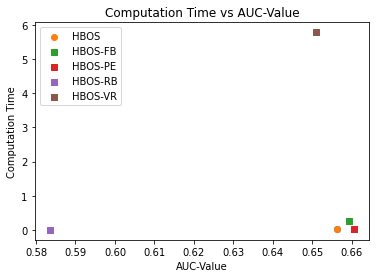

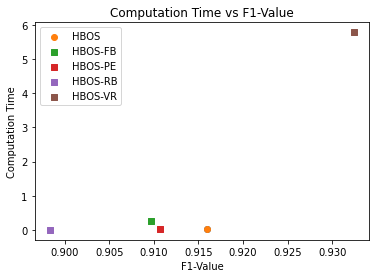

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


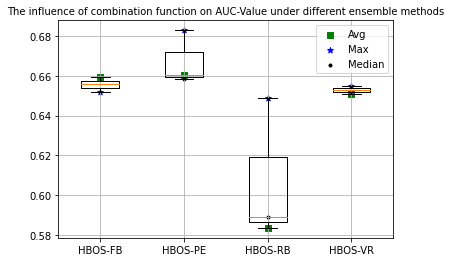

In [40]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_hbos,auc_fb_hbos, auc_pe_hbos, auc_rb_hbos , auc_vr_hbos]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_hbos,f1_fb_hbos, f1_pe_hbos, f1_rb_hbos , f1_vr_hbos]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()
#######

labels ='HBOS-FB', "HBOS-PE", 'HBOS-RB','HBOS-VR'
A = [auc_fb_hbos,auc_fb1_hbos]
B = [auc_pe_hbos, auc_pe1_hbos, auc_pe2_hbos]
C = [auc_rb_hbos, auc_rb1_hbos, auc_rb2_hbos]
D = [auc_vr_hbos,auc_vr1_hbos]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_hbos,auc_pe_hbos,auc_rb_hbos,auc_vr_hbos],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_hbos,auc_pe1_hbos,auc_rb1_hbos,auc_vr1_hbos],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_hbos,auc_rb2_hbos],label="Median",marker='.',c='k')
plt.legend()
plt.show()

In [41]:
# ##################################One-Class SVM
#ocsvm
fpr_ocsvm, tpr_ocsvm, f1_ocsvm, auc_ocsvm,time_train_ocsvm,time_test_ocsvm, recall_ocsvm, accuracy_ocsvm =baseline(X_train, X_test, y_train, y_test,model="ocsvm")


Base Detector:ocsvm
Total time:  120.61454749107361 s.

Training set:

Confusion Matrix : 
 [[21651  2043]
 [  849   457]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94     23694
           1       0.18      0.35      0.24      1306

    accuracy                           0.88     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.88      0.90     25000

Area Under Curve : 
 0.6318495348619865

Test set:

Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278


In [42]:
#feature bagging
fpr_fb_ocsvm, tpr_fb_ocsvm, f1_fb_ocsvm, auc_fb_ocsvm,time_train_fb_ocsvm,time_test_fb_ocsvm, recall_fb_ocsvm, accuracy_fb_ocsvm =feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Feature Bagging:
Total time:  1051.6056034564972 s.
training set:
Confusion Matrix : 
 [[21690  2004]
 [  810   496]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23694
           1       0.20      0.38      0.26      1306

    accuracy                           0.89     25000
   macro avg       0.58      0.65      0.60     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.647603615314246
test set:
Confusion Matrix : 
 [[21813  1917]
 [  832   438]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.34      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.91     25000

Area Under Curve : 
 0.63204903590591
f1: 0.905209758230319 auc: 0.63204903

In [43]:
fpr_fb1_ocsvm, tpr_fb1_ocsvm, f1_fb1_ocsvm, auc_fb1_ocsvm,time_train_fb1_max_ocsvm,time_test_fb1_max_ocsvm, recall_fb1_ocsvm, accuracy_fb1_ocsvm=feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Feature Bagging:
Total time:  1103.0473895072937 s.
training set:
Confusion Matrix : 
 [[21651  2043]
 [  849   457]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94     23694
           1       0.18      0.35      0.24      1306

    accuracy                           0.88     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.88      0.90     25000

Area Under Curve : 
 0.6318495348619865
test set:
Confusion Matrix : 
 [[21750  1980]
 [  870   400]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.31      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6157609723563315
f1: 0.9019691980316532 auc: 0.6157

In [44]:
#parameter ensemble
fpr_pe_ocsvm, tpr_pe_ocsvm, f1_pe_ocsvm, auc_pe_ocsvm,time_train_pe_ocsvm,time_test_pe_ocsvm, recall_pe_ocsvm, accuracy_pe_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm")


parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278
parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278
parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [45]:
fpr_pe1_ocsvm, tpr_pe1_ocsvm, f1_pe1_ocsvm, auc_pe1_ocsvm,time_train_pe1_max_ocsvm,time_test_pe1_max_ocsvm, recall_pe1_ocsvm, accuracy_pe1_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278
parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278
parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [46]:
fpr_pe2_ocsvm, tpr_pe2_ocsvm, f1_pe2_ocsvm, auc_pe2_ocsvm,time_train_pe2_median_ocsvm,time_test_pe2_median_ocsvm, recall_pe2_ocsvm, accuracy_pe2_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278
parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.32      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6161125323936278
parameter ensemble:
Confusion Matrix : 
 [[21748  1982]
 [  869   401]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [47]:
#rotated bagging
fpr_rb_ocsvm, tpr_rb_ocsvm, f1_rb_ocsvm, auc_rb_ocsvm,time_train_rb_ocsvm,time_test_rb_ocsvm, recall_rb_ocsvm, accuracy_rb_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Confusion Matrix : 
 [[21773  1957]
 [  877   393]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.31      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.56      0.61      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6134896854707321
Confusion Matrix : 
 [[21831  1899]
 [  844   426]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.18      0.34      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.91     25000

Area Under Curve : 
 0.6277038932080392
Confusion Matrix : 
 [[21781  1949]
 [  814   456]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [48]:
fpr_rb1_ocsvm, tpr_rb1_ocsvm, f1_rb1_ocsvm, auc_rb1_ocsvm,time_train_rb1_max_ocsvm,time_test_rb1_max_ocsvm, recall_rb1_ocsvm, accuracy_rb1_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Confusion Matrix : 
 [[21780  1950]
 [  825   445]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.35      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6341096190409827
Confusion Matrix : 
 [[21817  1913]
 [  768   502]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.40      0.27      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.66      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6573301677998215
Confusion Matrix : 
 [[21737  1993]
 [  813   457]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [49]:
fpr_rb2_ocsvm, tpr_rb2_ocsvm, f1_rb2_ocsvm, auc_rb2_ocsvm,time_train_rb2_median_ocsvm,time_test_rb2_median_ocsvm, recall_rb2_ocsvm, accuracy_rb2_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


Confusion Matrix : 
 [[21835  1895]
 [  859   411]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.18      0.32      0.23      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.62      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6218826628972264
Confusion Matrix : 
 [[21785  1945]
 [  873   397]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.17      0.31      0.22      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.62      0.58     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6153173331209705
Confusion Matrix : 
 [[21807  1923]
 [  852   418]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [50]:
#variable sampling with rotated bagging
fpr_vr_ocsvm, tpr_vr_ocsvm, f1_vr_ocsvm, auc_vr_ocsvm,time_train_vr_ocsvm,time_test_vr_ocsvm, recall_vr_ocsvm, accuracy_vr_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",threshold=1.2,loop=30)


Confusion Matrix : 
 [[22761   933]
 [ 1162   144]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     23694
           1       0.13      0.11      0.12      1306

    accuracy                           0.92     25000
   macro avg       0.54      0.54      0.54     25000
weighted avg       0.91      0.92      0.91     25000

Area Under Curve : 
 0.535441639711839
Confusion Matrix : 
 [[22834   896]
 [ 1142   128]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     23730
           1       0.12      0.10      0.11      1270

    accuracy                           0.92     25000
   macro avg       0.54      0.53      0.53     25000
weighted avg       0.91      0.92      0.91     25000

Area Under Curve : 
 0.5315146447402039
VR Total time:  1.353898286819458 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [51]:
fpr_vr1_ocsvm, tpr_vr1_ocsvm, f1_vr1_ocsvm, auc_vr1_ocsvm,time_train_vr1_max_ocsvm,time_test_vr1_max_ocsvm, recall_vr1_ocsvm, accuracy_vr1_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",combination_function="max",threshold=1.2,loop=100,mul=30)


Confusion Matrix : 
 [[19785  3909]
 [  732   574]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.84      0.90     23694
           1       0.13      0.44      0.20      1306

    accuracy                           0.81     25000
   macro avg       0.55      0.64      0.55     25000
weighted avg       0.92      0.81      0.86     25000

Area Under Curve : 
 0.6372657392473795
Confusion Matrix : 
 [[19917  3813]
 [  769   501]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.84      0.90     23730
           1       0.12      0.39      0.18      1270

    accuracy                           0.82     25000
   macro avg       0.54      0.62      0.54     25000
weighted avg       0.92      0.82      0.86     25000

Area Under Curve : 
 0.6169027544123357
VR Total time:  3966.3565607070923 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


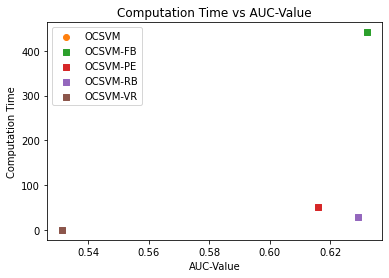

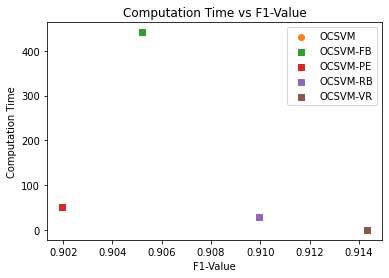

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


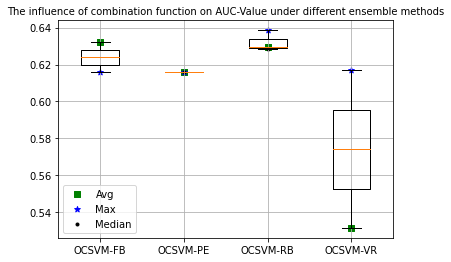

In [52]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ocsvm,auc_fb_ocsvm, auc_pe_ocsvm, auc_rb_ocsvm , auc_vr_ocsvm]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ocsvm,f1_fb_ocsvm, f1_pe_ocsvm, f1_rb_ocsvm , f1_vr_ocsvm]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='OCSVM-FB', "OCSVM-PE", 'OCSVM-RB','OCSVM-VR'

A = [auc_fb_ocsvm,auc_fb1_ocsvm]
B = [auc_pe_ocsvm, auc_pe1_ocsvm, auc_pe2_ocsvm]
C = [auc_rb_ocsvm, auc_rb1_ocsvm, auc_rb2_ocsvm]
D = [auc_vr_ocsvm,auc_vr1_ocsvm]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ocsvm,auc_pe_ocsvm,auc_rb_ocsvm,auc_vr_ocsvm],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ocsvm,auc_pe1_ocsvm,auc_rb1_ocsvm,auc_vr1_ocsvm],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ocsvm,auc_rb2_ocsvm],label="Median",marker='.',c='k')
#
plt.legend()
plt.show()


In [53]:
##################################IForest
#iforest
fpr_ifo, tpr_ifo, f1_ifo, auc_ifo,time_train_ifo,time_test_ifo,recall_ifo, accuracy_ifo =baseline(X_train, X_test, y_train, y_test,model="iforest")


Base Detector:iforest
Total time:  3.484055757522583 s.

Training set:

Confusion Matrix : 
 [[21746  1948]
 [  765   541]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23694
           1       0.22      0.41      0.29      1306

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6660135267281628

Test set:

Confusion Matrix : 
 [[21758  1972]
 [  797   473]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.37      0.25      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.64      0.60     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.644669692837068


In [54]:
#feature bagging
fpr_fb_ifo, tpr_fb_ifo, f1_fb_ifo, auc_fb_ifo,time_train_fb_ifo,time_test_fb_ifo,recall_fb_ifo, accuracy_fb_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Feature Bagging:
Total time:  30.594834327697754 s.
training set:
Confusion Matrix : 
 [[21699  1995]
 [  802   504]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23694
           1       0.20      0.39      0.26      1306

    accuracy                           0.89     25000
   macro avg       0.58      0.65      0.60     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6508563239496536
test set:
Confusion Matrix : 
 [[21747  1983]
 [  816   454]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.36      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.64      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6369576037508585
f1: 0.9042518541488161 auc: 0.6369

In [55]:
fpr_fb1_ifo, tpr_fb1_ifo, f1_fb1_ifo, auc_fb1_ifo,time_train_fb1_max_ifo,time_test_fb1_max_ifo,recall_fb1_ifo, accuracy_fb1_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Feature Bagging:
Total time:  30.045770406723022 s.
training set:
Confusion Matrix : 
 [[21696  1998]
 [  804   502]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23694
           1       0.20      0.38      0.26      1306

    accuracy                           0.89     25000
   macro avg       0.58      0.65      0.60     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6500273199992089
test set:
Confusion Matrix : 
 [[21783  1947]
 [  824   446]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.35      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6345665309535423
f1: 0.9048074941953785 auc: 0.6345

In [56]:
#parameter ensemble
fpr_pe_ifo, tpr_pe_ifo, f1_pe_ifo, auc_pe_ifo,time_train_pe_ifo,time_test_pe_ifo,recall_pe_ifo, accuracy_pe_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest")


parameter ensemble:
Confusion Matrix : 
 [[21719  2011]
 [  826   444]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.18      0.35      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6324306253753679
parameter ensemble:
Confusion Matrix : 
 [[21777  1953]
 [  804   466]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.37      0.25      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.64      0.60     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6423141244512577
parameter ensemble:
Confusion Matrix : 
 [[21719  2011]
 [  841   429]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [57]:
fpr_pe1_ifo, tpr_pe1_ifo, f1_pe1_ifo, auc_pe1_ifo,time_train_pe1_max_ifo,time_test_pe1_max_ifo,recall_pe1_ifo, accuracy_pe1_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[21745  1985]
 [  817   453]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.36      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.64      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6365217622133517
parameter ensemble:
Confusion Matrix : 
 [[21744  1986]
 [  844   426]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.18      0.34      0.23      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6258707705784564
parameter ensemble:
Confusion Matrix : 
 [[21777  1953]
 [  797   473]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [58]:
fpr_pe2_ifo, tpr_pe2_ifo, f1_pe2_ifo, auc_pe2_ifo,time_train_pe2_median_ifo,time_test_pe2_median_ifo,recall_pe2_ifo, accuracy_pe2_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[21797  1933]
 [  823   447]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.35      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.64      0.59     25000
weighted avg       0.92      0.89      0.91     25000

Area Under Curve : 
 0.6352552169916814
parameter ensemble:
Confusion Matrix : 
 [[21738  1992]
 [  804   466]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.19      0.37      0.25      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.64      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6414923798242034
parameter ensemble:
Confusion Matrix : 
 [[21744  1986]
 [  845   425]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [59]:
#rotated bagging
fpr_rb_ifo, tpr_rb_ifo, f1_rb_ifo, auc_rb_ifo,time_train_rb_ifo,time_test_rb_ifo,recall_rb_ifo, accuracy_rb_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Confusion Matrix : 
 [[21831  1899]
 [  802   468]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.20      0.37      0.26      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.64      0.60     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6442393262789055
Confusion Matrix : 
 [[21856  1874]
 [  771   499]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.39      0.27      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.66      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6569708100646712
Confusion Matrix : 
 [[21749  1981]
 [  911   359]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [60]:
fpr_rb1_ifo, tpr_rb1_ifo, f1_rb1_ifo, auc_rb1_ifo,time_train_rb1_max_ifo,time_test_rb1_max_ifo,recall_rb1_ifo, accuracy_rb1_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Confusion Matrix : 
 [[21742  1988]
 [  823   447]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     23730
           1       0.18      0.35      0.24      1270

    accuracy                           0.89     25000
   macro avg       0.57      0.63      0.59     25000
weighted avg       0.92      0.89      0.90     25000

Area Under Curve : 
 0.6340963463637842
Confusion Matrix : 
 [[21813  1917]
 [  747   523]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.21      0.41      0.28      1270

    accuracy                           0.89     25000
   macro avg       0.59      0.67      0.61     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6655136028350438
Confusion Matrix : 
 [[21805  1925]
 [  798   472]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [61]:
fpr_rb2_ifo, tpr_rb2_ifo, f1_rb2_ifo, auc_rb2_ifo,time_train_rb2_median_ifo,time_test_rb2_median_ifo,recall_rb2_ifo, accuracy_rb2_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


Confusion Matrix : 
 [[21761  1969]
 [  775   495]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     23730
           1       0.20      0.39      0.27      1270

    accuracy                           0.89     25000
   macro avg       0.58      0.65      0.60     25000
weighted avg       0.93      0.89      0.91     25000

Area Under Curve : 
 0.6533943212850606
Confusion Matrix : 
 [[21637  2093]
 [  943   327]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     23730
           1       0.14      0.26      0.18      1270

    accuracy                           0.88     25000
   macro avg       0.55      0.58      0.56     25000
weighted avg       0.92      0.88      0.90     25000

Area Under Curve : 
 0.5846398624950642
Confusion Matrix : 
 [[21694  2036]
 [  865   405]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [62]:
#variable sampling with rotated bagging
fpr_vr_ifo, tpr_vr_ifo, f1_vr_ifo, auc_vr_ifo,time_train_vr_ifo,time_test_vr_ifo,recall_vr_ifo, accuracy_vr_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",threshold=1.2,loop=30)


Confusion Matrix : 
 [[22989   705]
 [ 1149   157]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     23694
           1       0.18      0.12      0.14      1306

    accuracy                           0.93     25000
   macro avg       0.57      0.55      0.55     25000
weighted avg       0.91      0.93      0.92     25000

Area Under Curve : 
 0.5452300134525305
Confusion Matrix : 
 [[22988   742]
 [ 1141   129]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     23730
           1       0.15      0.10      0.12      1270

    accuracy                           0.92     25000
   macro avg       0.55      0.54      0.54     25000
weighted avg       0.91      0.92      0.92     25000

Area Under Curve : 
 0.5351531832857175
VR Total time:  7.286734580993652 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [63]:
fpr_vr1_ifo, tpr_vr1_ifo, f1_vr1_ifo, auc_vr1_ifo,time_train_vr1_max_ifo,time_test_vr1_max_ifo,recall_vr1_ifo, accuracy_vr1_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",combination_function="max",threshold=1.2,loop=100,mul=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Confusion Matrix : 
 [[19609  4085]
 [  636   670]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.83      0.89     23694
           1       0.14      0.51      0.22      1306

    accuracy                           0.81     25000
   macro avg       0.55      0.67      0.56     25000
weighted avg       0.93      0.81      0.86     25000

Area Under Curve : 
 0.6703051644557956
Confusion Matrix : 
 [[19687  4043]
 [  671   599]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.83      0.89     23730
           1       0.13      0.47      0.20      1270

    accuracy                           0.81     25000
   macro avg       0.55      0.65      0.55     25000
weighted avg       0.92      0.81      0.86     25000

Area Under Curve : 
 0.6506392453155745
VR Total time:  140.3951768875122 s.


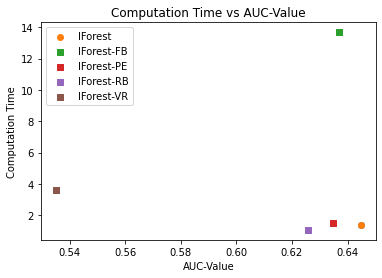

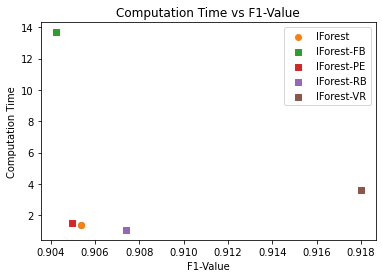

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


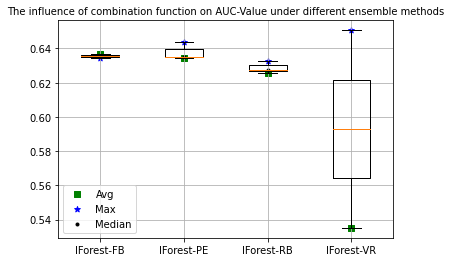

In [64]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ifo,auc_fb_ifo, auc_pe_ifo, auc_rb_ifo , auc_vr_ifo]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ifo,f1_fb_ifo, f1_pe_ifo, f1_rb_ifo , f1_vr_ifo]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='IForest-FB', "IForest-PE", 'IForest-RB','IForest-VR'

A = [auc_fb_ifo,auc_fb1_ifo]
B = [auc_pe_ifo, auc_pe1_ifo, auc_pe2_ifo]
C = [auc_rb_ifo, auc_rb1_ifo, auc_rb2_ifo]
D = [auc_vr_ifo,auc_vr1_ifo]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ifo,auc_pe_ifo,auc_rb_ifo,auc_vr_ifo],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ifo,auc_pe1_ifo,auc_rb1_ifo,auc_vr1_ifo],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ifo,auc_rb2_ifo],label="Median",marker='.',c='k')

plt.legend()
plt.show()


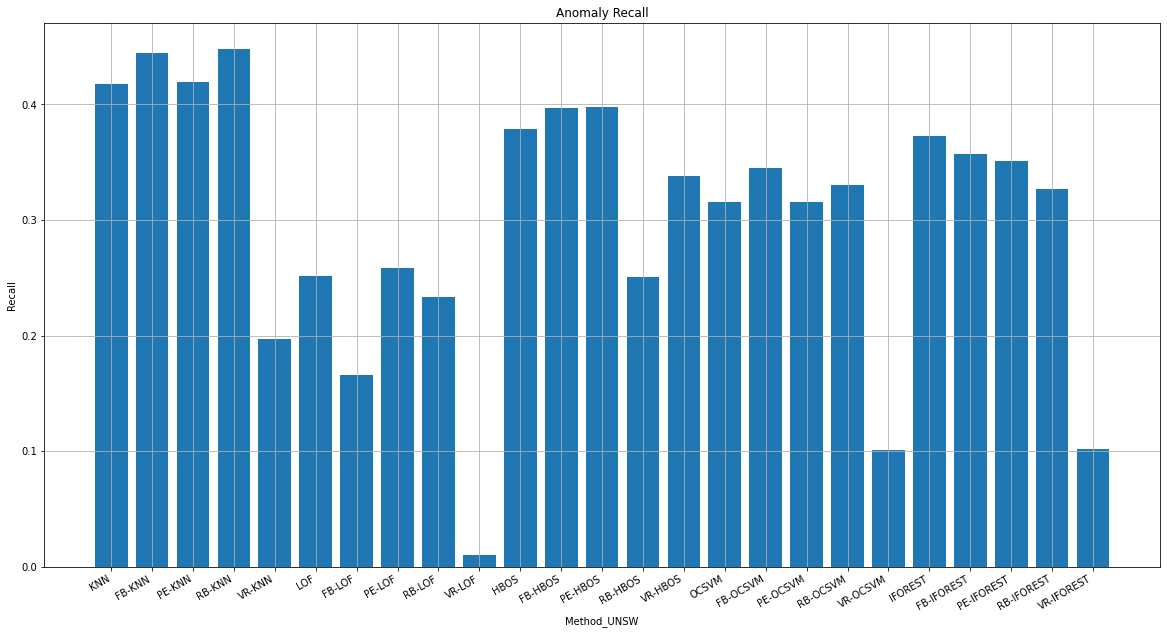

In [65]:
## recall ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [recall_knn,recall_fb_knn,recall_pe_knn,recall_rb_knn,recall_vr_knn,
     recall_lof,recall_fb_lof,recall_pe_lof,recall_rb_lof,recall_vr_lof,
     recall_hbos,recall_fb_hbos,recall_pe_hbos,recall_rb_hbos,recall_vr_hbos,
     recall_ocsvm,recall_fb_ocsvm,recall_pe_ocsvm,recall_rb_ocsvm,recall_vr_ocsvm,
     recall_ifo,recall_fb_ifo,recall_pe_ifo,recall_rb_ifo,recall_vr_ifo]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST']
ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Anomaly Recall")
plt.xlabel("Method_UNSW")
plt.ylabel("Recall")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()




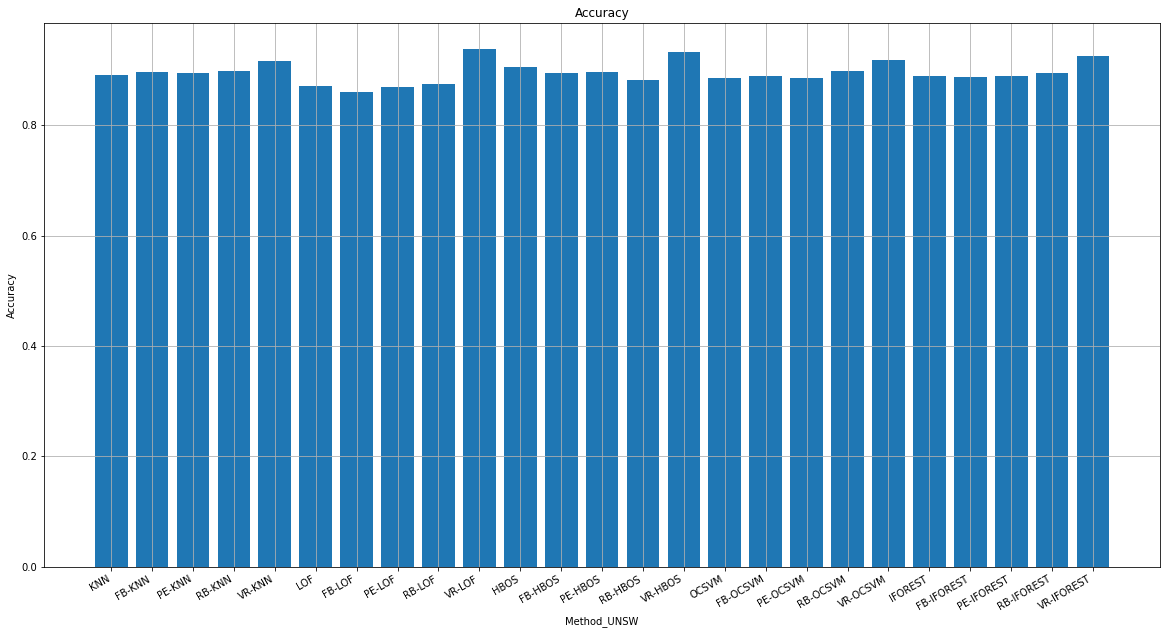

In [66]:
## Accuracy ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [accuracy_knn,accuracy_fb_knn,accuracy_pe_knn,accuracy_rb_knn,accuracy_vr_knn,
     accuracy_lof,accuracy_fb_lof,accuracy_pe_lof,accuracy_rb_lof,accuracy_vr_lof,
     accuracy_hbos,accuracy_fb_hbos,accuracy_pe_hbos,accuracy_rb_hbos,accuracy_vr_hbos,
     accuracy_ocsvm,accuracy_fb_ocsvm,accuracy_pe_ocsvm,accuracy_rb_ocsvm,accuracy_vr_ocsvm,
     accuracy_ifo,accuracy_fb_ifo,accuracy_pe_ifo,accuracy_rb_ifo,accuracy_vr_ifo]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST']

ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Accuracy")
plt.xlabel("Method_UNSW")
plt.ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()

In [67]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','AUC','F1-Score','total time'])

model_performance.loc['KNN'] = [accuracy_knn, recall_knn, auc_knn, f1_knn,time_test_knn+time_train_knn]
model_performance.loc['FB-KNN_MEAN'] = [accuracy_fb_knn, recall_fb_knn, auc_fb_knn, f1_fb_knn,time_test_fb_knn+time_train_fb_knn]
model_performance.loc['FB-KNN_MAX'] = [accuracy_fb1_knn, recall_fb1_knn, auc_fb1_knn, f1_fb1_knn,time_test_fb1_max_knn+time_train_fb1_max_knn]
model_performance.loc['PE-KNN_MEAN'] = [accuracy_pe_knn, recall_pe_knn, auc_pe_knn, f1_pe_knn,time_test_pe_knn+time_train_pe_knn]
model_performance.loc['PE-KNN_MAX'] = [accuracy_pe1_knn, recall_pe1_knn, auc_pe1_knn, f1_pe1_knn,time_test_pe1_max_knn+time_train_pe1_max_knn]
model_performance.loc['PE-KNN_MEDIAN'] = [accuracy_pe2_knn, recall_pe2_knn, auc_pe2_knn, f1_pe2_knn,time_test_pe2_median_knn+time_train_pe2_median_knn]
model_performance.loc['RB-KNN_MEAN'] = [accuracy_rb_knn, recall_rb_knn, auc_rb_knn, f1_rb_knn,time_test_rb_knn+time_train_rb_knn]
model_performance.loc['RB-KNN_MAX'] = [accuracy_rb1_knn, recall_rb1_knn, auc_rb1_knn, f1_rb1_knn,time_test_rb1_max_knn+time_train_rb1_max_knn]
model_performance.loc['RB-KNN_MEDIAN'] = [accuracy_rb2_knn, recall_rb2_knn, auc_rb2_knn, f1_rb2_knn,time_test_rb2_median_knn+time_train_rb2_median_knn]
model_performance.loc['VR-KNN_MEAN'] = [accuracy_vr_knn, recall_vr_knn, auc_vr_knn, f1_vr_knn,time_test_vr_knn+time_train_vr_knn]
model_performance.loc['VR-KNN_MAX'] = [accuracy_vr1_knn, recall_vr1_knn, auc_vr1_knn, f1_vr1_knn,time_test_vr1_max_knn+time_train_vr1_max_knn]

model_performance.loc['LOF'] = [accuracy_lof, recall_lof, auc_lof, f1_lof,time_test_lof+time_train_lof]
model_performance.loc['FB-LOF_MEAN'] = [accuracy_fb_lof, recall_fb_lof, auc_fb_lof, f1_fb_lof,time_test_fb_lof+time_train_fb_lof]
model_performance.loc['FB-LOF_MAX'] = [accuracy_fb1_lof, recall_fb1_lof, auc_fb1_lof, f1_fb1_lof,time_test_fb1_max_lof+time_train_fb1_max_lof]
model_performance.loc['PE-LOF_MEAN'] = [accuracy_pe_lof, recall_pe_lof, auc_pe_lof, f1_pe_lof,time_test_pe_lof+time_train_pe_lof]
model_performance.loc['PE-LOF_MAX'] = [accuracy_pe1_lof, recall_pe1_lof, auc_pe1_lof, f1_pe1_lof,time_test_pe1_max_lof+time_train_pe1_max_lof]
model_performance.loc['PE-LOF_MEDIAN'] = [accuracy_pe2_lof, recall_pe2_lof, auc_pe2_lof, f1_pe2_lof,time_test_pe2_median_lof+time_train_pe2_median_lof]
model_performance.loc['RB-LOF_MEAN'] = [accuracy_rb_lof, recall_rb_lof, auc_rb_lof, f1_rb_lof,time_test_rb_lof+time_train_rb_lof]
model_performance.loc['RB-LOF_MAX'] = [accuracy_rb1_lof, recall_rb1_lof, auc_rb1_lof, f1_rb1_lof,time_test_rb1_max_lof+time_train_rb1_max_lof]
model_performance.loc['RB-LOF_MEDIAN'] = [accuracy_rb2_lof, recall_rb2_lof, auc_rb2_lof, f1_rb2_lof,time_test_rb2_median_lof+time_train_rb2_median_lof]
model_performance.loc['VR-LOF_MEAN'] = [accuracy_vr_lof, recall_vr_lof, auc_vr_lof, f1_vr_lof,time_test_vr_lof+time_train_vr_lof]
model_performance.loc['VR-LOF_MAX'] = [accuracy_vr1_lof, recall_vr1_lof, auc_vr1_lof, f1_vr1_lof,time_test_vr1_max_lof+time_train_vr1_max_lof]

model_performance.loc['HBOS'] = [accuracy_hbos, recall_hbos, auc_hbos, f1_hbos,time_test_hbos+time_train_hbos]
model_performance.loc['FB-HBOS_MEAN'] = [accuracy_fb_hbos, recall_fb_hbos, auc_fb_hbos, f1_fb_hbos,time_test_fb_hbos+time_train_fb_hbos]
model_performance.loc['FB-HBOS_MAX'] = [accuracy_fb1_hbos, recall_fb1_hbos, auc_fb1_hbos, f1_fb1_hbos,time_test_fb1_max_hbos+time_train_fb1_max_hbos]
model_performance.loc['PE-HBOS_MEAN'] = [accuracy_pe_hbos, recall_pe_hbos, auc_pe_hbos, f1_pe_hbos,time_test_pe_hbos+time_train_pe_hbos]
model_performance.loc['PE-HBOS_MAX'] = [accuracy_pe1_hbos, recall_pe1_hbos, auc_pe1_hbos, f1_pe1_hbos,time_test_pe1_max_hbos+time_train_pe1_max_hbos]
model_performance.loc['PE-HBOS_MEDIAN'] = [accuracy_pe2_hbos, recall_pe2_hbos, auc_pe2_hbos, f1_pe2_hbos,time_test_pe2_median_hbos+time_train_pe2_median_hbos]
model_performance.loc['RB-HBOS_MEAN'] = [accuracy_rb_hbos, recall_rb_hbos, auc_rb_hbos, f1_rb_hbos,time_test_rb_hbos+time_train_rb_hbos]
model_performance.loc['RB-HBOS_MAX'] = [accuracy_rb1_hbos, recall_rb1_hbos, auc_rb1_hbos, f1_rb1_hbos,time_test_rb1_max_hbos+time_train_rb1_max_hbos]
model_performance.loc['RB-HBOS_MEDIAN'] = [accuracy_rb2_hbos, recall_rb2_hbos, auc_rb2_hbos, f1_rb2_hbos,time_test_rb2_median_hbos+time_train_rb2_median_hbos]
model_performance.loc['VR-HBOS_MEAN'] = [accuracy_vr_hbos, recall_vr_hbos, auc_vr_hbos, f1_vr_hbos,time_test_vr_hbos+time_train_vr_hbos]
model_performance.loc['VR-HBOS_MAX'] = [accuracy_vr1_hbos, recall_vr1_hbos, auc_vr1_hbos, f1_vr1_hbos,time_test_vr1_max_hbos+time_train_vr1_max_hbos]

model_performance.loc['OCSVM'] = [accuracy_ocsvm, recall_ocsvm, auc_ocsvm, f1_ocsvm,time_test_ocsvm+time_train_ocsvm]
model_performance.loc['FB-OCSVM_MEAN'] = [accuracy_fb_ocsvm, recall_fb_ocsvm, auc_fb_ocsvm, f1_fb_ocsvm,time_test_fb_ocsvm+time_train_fb_ocsvm]
model_performance.loc['FB-OCSVM_MAX'] = [accuracy_fb1_ocsvm, recall_fb1_ocsvm, auc_fb1_ocsvm, f1_fb1_ocsvm,time_test_fb1_max_ocsvm+time_train_fb1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEAN'] = [accuracy_pe_ocsvm, recall_pe_ocsvm, auc_pe_ocsvm, f1_pe_ocsvm,time_test_pe_ocsvm+time_train_pe_ocsvm]
model_performance.loc['PE-OCSVM_MAX'] = [accuracy_pe1_ocsvm, recall_pe1_ocsvm, auc_pe1_ocsvm, f1_pe1_ocsvm,time_test_pe1_max_ocsvm+time_train_pe1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEDIAN'] = [accuracy_pe2_ocsvm, recall_pe2_ocsvm, auc_pe2_ocsvm, f1_pe2_ocsvm,time_test_pe2_median_ocsvm+time_train_pe2_median_ocsvm]
model_performance.loc['RB-OCSVM_MEAN'] = [accuracy_rb_ocsvm, recall_rb_ocsvm, auc_rb_ocsvm, f1_rb_ocsvm,time_test_rb_ocsvm+time_train_rb_ocsvm]
model_performance.loc['RB-OCSVM_MAX'] = [accuracy_rb1_ocsvm, recall_rb1_ocsvm, auc_rb1_ocsvm, f1_rb1_ocsvm,time_test_rb1_max_ocsvm+time_train_rb1_max_ocsvm]
model_performance.loc['RB-OCSVM_MEDIAN'] = [accuracy_rb2_ocsvm, recall_rb2_ocsvm, auc_rb2_ocsvm, f1_rb2_ocsvm,time_test_rb2_median_ocsvm+time_train_rb2_median_ocsvm]
model_performance.loc['VR-OCSVM_MEAN'] = [accuracy_vr_ocsvm, recall_vr_ocsvm, auc_vr_ocsvm, f1_vr_ocsvm,time_test_vr_ocsvm+time_train_vr_ocsvm]
model_performance.loc['VR-OCSVM_MAX'] = [accuracy_vr1_ocsvm, recall_vr1_ocsvm, auc_vr1_ocsvm, f1_vr1_ocsvm,time_test_vr1_max_ocsvm+time_train_vr1_max_ocsvm]

model_performance.loc['IFOREST'] = [accuracy_ifo, recall_ifo, auc_ifo, f1_ifo,time_test_ifo+time_train_ifo]
model_performance.loc['FB-IFOREST_MEAN'] = [accuracy_fb_ifo, recall_fb_ifo, auc_fb_ifo, f1_fb_ifo,time_test_fb_ifo+time_train_fb_ifo]
model_performance.loc['FB-IFOREST_MAX'] = [accuracy_fb1_ifo, recall_fb1_ifo, auc_fb1_ifo, f1_fb1_ifo,time_test_fb1_max_ifo+time_train_fb1_max_ifo]
model_performance.loc['PE-IFOREST_MEAN'] = [accuracy_pe_ifo, recall_pe_ifo, auc_pe_ifo, f1_pe_ifo,time_test_pe_ifo+time_train_pe_ifo]
model_performance.loc['PE-IFOREST_MAX'] = [accuracy_pe1_ifo, recall_pe1_ifo, auc_pe1_ifo, f1_pe1_ifo,time_test_pe1_max_ifo+time_train_pe1_max_ifo]
model_performance.loc['PE-IFOREST_MEDIAN'] = [accuracy_pe2_ifo, recall_pe2_ifo, auc_pe2_ifo, f1_pe2_ifo,time_test_pe2_median_ifo+time_train_pe2_median_ifo]
model_performance.loc['RB-IFOREST_MEAN'] = [accuracy_rb_ifo, recall_rb_ifo, auc_rb_ifo, f1_rb_ifo,time_test_rb_ifo+time_train_rb_ifo]
model_performance.loc['RB-IFOREST_MAX'] = [accuracy_rb1_ifo, recall_rb1_ifo, auc_rb1_ifo, f1_rb1_ifo,time_test_rb1_max_ifo+time_train_rb1_max_ifo]
model_performance.loc['RB-IFOREST_MEDIAN'] = [accuracy_rb2_ifo, recall_rb2_ifo, auc_rb2_ifo, f1_rb2_ifo,time_test_rb2_median_ifo+time_train_rb2_median_ifo]
model_performance.loc['VR-IFOREST_MEAN'] = [accuracy_vr_ifo, recall_vr_ifo, auc_vr_ifo, f1_vr_ifo,time_test_vr_ifo+time_train_vr_ifo]
model_performance.loc['VR-IFOREST_MAX'] = [accuracy_vr1_ifo, recall_vr1_ifo, auc_vr1_ifo, f1_vr1_ifo,time_test_vr1_max_ifo+time_train_vr1_max_ifo]



In [68]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'AUC': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'total time':'{:.1f}'
                                                                     })

,Accuracy,Recall,AUC,F1-Score,total time
KNN,89.16%,41.81%,66.75%,90.79%,67.0
FB-KNN_MEAN,89.60%,44.49%,68.25%,91.12%,380.2
FB-KNN_MAX,89.16%,41.81%,66.75%,90.79%,484.0
PE-KNN_MEAN,89.40%,41.97%,66.95%,90.94%,53.1
PE-KNN_MAX,89.39%,42.99%,67.43%,90.96%,53.1
PE-KNN_MEDIAN,89.48%,41.97%,67.00%,91.00%,53.3
RB-KNN_MEAN,89.82%,44.80%,68.51%,91.27%,2.8
RB-KNN_MAX,85.52%,55.51%,71.32%,88.70%,2.8
RB-KNN_MEDIAN,89.96%,39.45%,66.06%,91.24%,2.8
VR-KNN_MEAN,91.72%,19.69%,57.63%,91.77%,2.6
